In [8]:
# imports 
import os
import shutil

In [2]:
# dataset location
covid_path = 'dataset/covid/'
non_covid_path = 'dataset/no_covid/'

base_directory = 'dataset/content/'

In [3]:
# this function has been adapted from the 
# https://github.com/sagihaider/TransferLearning_COVID19 github repo created by Dr. Haider
def rename_dataset_files(path, class_handler):
    for count, filename in enumerate(os.listdir(path)): 
        dst = class_handler + "-" + str(count) + ".png"
        src = path + filename 
        dst = path + dst 
        
        os.rename(src, dst)
    
    print(class_handler, count)

In [4]:
rename_dataset_files(covid_path, "covid")
rename_dataset_files(non_covid_path, "non-covid")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'dataset/covid/covid-10.png' -> 'dataset/covid/covid-2.png'

In [8]:
# create folders for the dataset split
if not os.path.exists(base_directory):
    os.mkdir(base_directory)
    
train_dir = os.path.join(base_directory, 'train')
if not os.path.exists(train_dir): 
    os.mkdir(train_dir)

validation_dir = os.path.join(base_directory, 'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)

test_dir = os.path.join(base_directory, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

In [16]:
# copy the files from the dataset into the train, validation and test sets
def copy_files_from_dataset(source, destination, fname_format, lower_limit, upper_limit):
    fnames = [fname_format.format(i) for i in range(lower_limit, upper_limit)]
    
    # clear the destination folder in case the range is modified
    # this needs to be made a separate function or smth because it removes the covid images when adding the non-covid
#     for file in os.listdir(destination):
#         os.remove(os.path.join(destination, file))
    
    for fname in fnames: 
        src = os.path.join(source, fname)
        dst = os.path.join(destination, fname)
        
        shutil.copyfile(src, dst)

In [17]:
# copy covid
copy_files_from_dataset(covid_path, train_dir, 'covid-{}.png', 0, 250)
copy_files_from_dataset(covid_path, validation_dir, 'covid-{}.png', 250, 300)
copy_files_from_dataset(covid_path, test_dir, 'covid-{}.png', 300, 348)

# copy non-covid
copy_files_from_dataset(non_covid_path, train_dir, 'non-covid-{}.png', 0, 250)
copy_files_from_dataset(non_covid_path, validation_dir, 'non-covid-{}.png', 250, 300)
copy_files_from_dataset(non_covid_path, test_dir, 'non-covid-{}.png', 300, 348)

In [23]:
import cv2
import numpy as np
from random import shuffle

# IMG_SIZE = 224 # VGG16
IMG_SIZE = 227 # alexnet
LR = 1e-4

In [6]:
def label_img(img):
    word_label = img.split('-')[0]
    if word_label == 'covid': return 1
    elif word_label == 'non': return 0
    
    
    
def createDataSplitSet(datapath):
    X=[]
    y=[]

    for img in os.listdir(datapath):
        label = label_img(img)
        path = os.path.join(datapath, img)
        image = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        X.append(np.array(image))
        y.append(label)

    return np.array(X), np.array(y)

In [24]:
train_X, train_y = createDataSplitSet(train_dir)
val_X, val_y = createDataSplitSet(validation_dir)
test_X, test_y = createDataSplitSet(test_dir)
print(train_X.shape)
print(val_X.shape)
print(test_X.shape)

(500, 227, 227, 3)
(100, 227, 227, 3)
(96, 227, 227, 3)


In [25]:
## VGG 16

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras import Model

from tensorflow import keras

img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

In [31]:
# VGG16 model
model_save = 'vgg16_model.h5'

model = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

last_layer = model.get_layer('block5_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(64, activation='relu', name='fc2')(x)
out = Dense(1, activation='sigmoid', name='output')(x)  ## 2 classes
model = Model(img_input, out)

for layer in model.layers[:-3]:
    layer.trainable = False

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 227, 227, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 227, 227, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 113, 113, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 113, 113, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 113, 113, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [52]:
# alexnet model
# uses 227x227 input
model_save = 'alexnet_model.h5'

model = keras.models.Sequential([
        keras.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu',
                            input_shape=(227, 227, 3)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
        keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
        keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=384, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), name='tomas'),
        keras.layers.Flatten(),
#         keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dense(128, activation='relu', name='fc1'),
        keras.layers.Dropout(0.1),
#         keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dense(64, activation='relu', name='fc2'),
        keras.layers.Dropout(0.1),
#         keras.layers.Dense(10, activation='softmax')
        keras.layers.Dense(1, activation='sigmoid', name='output')
    ])

# model.summary()

# last_layer = model.get_layer('tomas').output
# x= Flatten(name='flatten')(last_layer)
# x = Dense(128, activation='relu', name='fc1')(x)
# x = Dense(64, activation='relu', name='fc2')(x)
# out = Dense(1, activation='sigmoid', name='output')(x)  ## 2 classes
# model = Model(img_input, out)

# for layer in model.layers[:-3]:
#     layer.trainable = False

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_50 (Batc (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_51 (Batc (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 13, 13, 384)     

In [57]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath=model_save, save_best_only=True),
]

In [58]:
history = model.fit(train_X, train_y,
                              batch_size=5,
                              epochs=50, 
                              validation_data=(val_X, val_y),
                              callbacks=my_callbacks)

Epoch 1/50
100/100 [==============================] - 10s 97ms/step - loss: 0.6274 - acc: 0.7120 - val_loss: 0.7105 - val_acc: 0.6300
Epoch 2/50
100/100 [==============================] - 10s 98ms/step - loss: 0.5520 - acc: 0.7260 - val_loss: 0.7962 - val_acc: 0.6500
Epoch 3/50
100/100 [==============================] - 10s 96ms/step - loss: 0.4406 - acc: 0.7920 - val_loss: 0.8452 - val_acc: 0.6800
Epoch 4/50
100/100 [==============================] - 10s 103ms/step - loss: 0.4209 - acc: 0.8320 - val_loss: 0.6515 - val_acc: 0.6600
Epoch 5/50
100/100 [==============================] - 10s 101ms/step - loss: 0.4133 - acc: 0.8400 - val_loss: 0.8229 - val_acc: 0.6400
Epoch 6/50
100/100 [==============================] - 10s 97ms/step - loss: 0.4085 - acc: 0.8320 - val_loss: 0.9546 - val_acc: 0.6700
Epoch 7/50
100/100 [==============================] - 10s 97ms/step - loss: 0.3477 - acc: 0.8540 - val_loss: 0.7560 - val_acc: 0.6600
Epoch 8/50
100/100 [==============================] - 10s 97

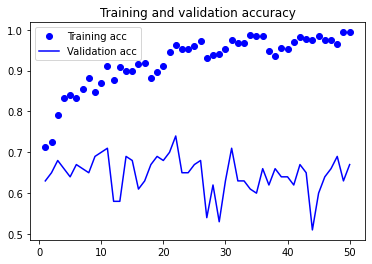

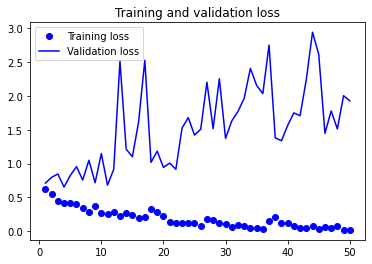

In [59]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [60]:
from sklearn.metrics import accuracy_score

## Test Accuracy
predictions = model.predict(test_X)
ypred = predictions > 0.5
test_acc = accuracy_score(test_y, ypred)

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1score, _ = precision_recall_fscore_support(test_y, ypred, average='binary')

auc = roc_auc_score(test_y, ypred)

print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)


Train Accuracy:	 0.9940000176429749
Val Accuracy:	 0.6700000166893005
Test Accuracy:	 0.6145833333333334
Precision:	 0.5901639344262295
Recall:		 0.75
F1 Score:	 0.6605504587155964
AUC:		 0.6145833333333333
